In [1]:
import torch
import numpy as np 
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import umap

from VAE import * 
import os

In [2]:
pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(), 
])

class WikiArtsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None): 
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform 
        self.target_transform = target_transform
        
    def __len__(self): 
        return len(self.img_labels)
    
    def __getitem__(self, idx): 
        img_path = self.img_labels.iloc[idx, 0]
        #image = read_image(img_path)
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, img_path


In [3]:
dataset = WikiArtsDataset("WikiArts_labeled.csv", img_dir=None, transform=transform)

In [4]:
generator = torch.Generator().manual_seed(40)
train_size = int(0.5*len(dataset))
valid_size = int(0.3*len(dataset))
test_size = len(dataset) - train_size - valid_size
train, valid, test = random_split(dataset, [train_size, valid_size, test_size], generator=generator)

In [5]:
print(len(train))
print(len(valid))
print(len(test))

40047
24028
16020


In [5]:
train_dataloader = DataLoader(train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test, batch_size=128, shuffle=True)

In [7]:
def train_vae(model, optimizer, encoder_model, decoder_model, alpha, num_epochs): 
 
    running_loss = []
    running_avg = 0
    i = 0
    
    for epoch in range(num_epochs): 
        epoch_loss = 0
        
        for x_batch, y_batch, imgpath in train_dataloader:

            x_batch = x_batch.to(device)
            
            #beta = min(1.0, epoch / 2)
            beta = 0.002
            
            optimizer.zero_grad()
            
            pred = model(x_batch)
            
            loss = vae_loss(pred, x_batch, beta)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            running_avg += loss.item()
            
            if (i+1) % 100 == 0: 
                print(running_avg/100)
                running_loss.append(running_avg / 100)
                running_avg = 0

            i += 1
        
        # scheduler.step(loss)
            
        print("===============EPOCH ", epoch, "=======================")
        print("Training loss: ", epoch_loss/len(train_dataloader))
    
    return running_loss
    

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
encoder_64 = Encoder(64, 128)
decoder_64 = Decoder(64, 64, 16, 16)
vae_64 = VAE(encoder_64, decoder_64)

In [12]:
encoder_64.to(device)
decoder_64.to(device)
vae_64.to(device) 

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchNorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchNorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (mean): Linear(in_features=16384, out_features=64, bias=True)
    (var): Linear(in_features=16384, out_features=64, bias=True)
    (sampling): Sampling()
  )
  (decoder): Decoder(
    (lin): Linear(in_features=64, out_features=16384, bias=True)
    (decoder): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1):

In [11]:
optimizer_64 = optim.Adam(vae_64.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0)

In [21]:
running_loss_64 = train_vae(vae_64, optimizer_64, encoder_64, decoder_64, 0.001, 1)

0.6243353539705276
0.6242993682622909
0.6244953006505967
===============EPOCH  0 =======================
Training loss:  0.6243916119630344


In [26]:
valid_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
evaluate_vae(vae_64, valid_dataloader)

0.6235819810882528


In [20]:
new_lr = 0.00001
for param_group in optimizer_64.param_groups:
    param_group['lr'] = new_lr

In [23]:
def evaluate_vae(model, valid_loader): 
    beta = 0.002
    model.eval()

    running_avg = 0

    with torch.no_grad(): 
        for x_batch, y_batch, img_path in valid_loader: 
            x_batch = x_batch.to(device)
            pred = model(x_batch)
            loss = vae_loss(pred, x_batch, beta)

            running_avg += loss.item()

    print(running_avg / len(valid_loader))
            

In [35]:
def save_latent(encoder, latent_name, labels_name): 
    encoder.eval()
    train_latents = []
    train_labels = []
    train_images = []

    encoder = encoder.to(device)
    print(device)

    with torch.no_grad():  
        i = 0
        for x_batch, y_batch, img_path in train_dataloader:

            x_batch = x_batch.to(device)

            mu, logvar, z = encoder(x_batch) 

            train_latents.append(mu.detach().cpu()) 
            train_labels.extend(y_batch)
            train_images.extend(img_path) 
            i+=1

            if i % 10 == 0: 
                print(i)


    train_latents = torch.cat(train_latents, dim=0) 
    torch.save(train_latents, latent_name)
    
    df = pd.DataFrame({'label': train_labels, 'img_paths': train_images})
    df.to_csv(labels_name, index=False)

In [36]:
save_latent(encoder_64, "vae64latents.pt", "vae64labels.csv")

cuda
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310


In [37]:
#torch.save(vae_64.state_dict(), "vae64weights.pt")

In [8]:
loaded_vae_model = torch.load("vae64weights.pt", map_location=device)
vae_64.load_state_dict(loaded_vae_model)

<All keys matched successfully>

In [9]:
vae_64.eval() # Set to evaluation mode
vae_64.to(device)
encoder_64.to(device)
decoder_64.to(device)

Decoder(
  (lin): Linear(in_features=64, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [10]:
latent_vectors = torch.load("vae64latents.pt")
latent_vectors_np = latent_vectors.numpy()
labels_df = pd.read_csv("vae64labels.csv")
genre_labels = labels_df['label'].values

In [28]:
single_loader = DataLoader(test, batch_size=1, shuffle=True)

('extracted/Impressionism/eugene-boudin_the-shore-at-villerville-1893.jpg',)
extracted/Impressionism/pericles-pantazis_lighthouse-of-marseille.jpg
extracted/Symbolism/james-ensor_at-the-conservatory-1902.jpg
extracted/Impressionism/kimon-loghi_biarritz-beach.jpg
extracted/Realism/johan-hendrik-weissenbruch_rowing-on-the-river.jpg
extracted/Baroque/adriaen-van-de-velde_golfers-on-the-ice-near-haarlem-1668.jpg


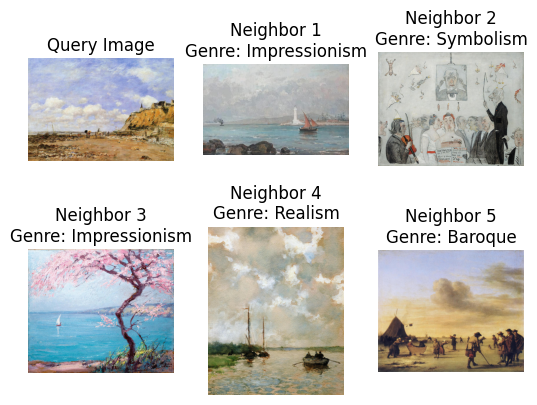

In [68]:
for sample_image, sample_label, sample_path in single_loader: 
    print(sample_path)
    with torch.no_grad(): 
        sample_image = sample_image.to(device)
        
        mu, var, output = vae_64(sample_image)
        #display_reconstruction(output)

        query_mu_np = mu.squeeze().detach().cpu().numpy()

        distances = np.linalg.norm(latent_vectors_np - query_mu_np, axis=1)

        # Get the indices of the N smallest distances
        neighbor_indices = np.argsort(distances)[:5]

        neighbor_info = labels_df.iloc[neighbor_indices]
        neighbor_paths = neighbor_info['img_paths'].tolist()

        query_img_pil = Image.open(sample_path[0]).convert('RGB')
        plt.subplot(2, 3, 1)
        plt.imshow(query_img_pil)
        plt.title("Query Image")
        plt.axis('off')

        for i, idx in enumerate(neighbor_indices):
            neighbor_path = neighbor_info.iloc[i]['img_paths']
            neighbor_label = neighbor_info.iloc[i]['label']
            distance = distances[idx]

        
            neighbor_img_pil = Image.open(neighbor_path).convert('RGB')
            print(neighbor_path)
            plt.subplot(2, 3, i+2) # Position in grid
            plt.imshow(neighbor_img_pil)
            plt.title(f"Neighbor {i+1}\nGenre: {neighbor_label}")
            plt.axis('off')


        # plt.tight_layout()
        plt.show()
        
        
        

    break
        
        

In [67]:
def display_reconstruction(reconstruction_tensor):
  
    if reconstruction_tensor is None:
        print("Reconstruction tensor is None. Cannot display.")
        return

   
    recon_detached = reconstruction_tensor.detach()
    recon_cpu = recon_detached.cpu()
    recon_squeezed = recon_cpu.squeeze(0)
    recon_display = recon_squeezed.permute(1, 2, 0)
    recon_display = torch.clamp(recon_display, 0, 1)

   
    plt.imshow(recon_display) 
    plt.title("Reconstructed Image")
    plt.axis('off') 
    plt.show()


In [14]:

from collections import Counter 
from sklearn.metrics import confusion_matrix

correct_predictions = 0
total_test_samples = 0

y_true = []
y_pred = []


for sample_image, sample_label, sample_path in single_loader: 
    
    with torch.no_grad(): 
        sample_image = sample_image.to(device)
        
        mu, var, output = vae_64(sample_image)
        #display_reconstruction(output)

        query_mu_np = mu.squeeze().detach().cpu().numpy()


        distances = np.linalg.norm(latent_vectors_np - query_mu_np, axis=1)

        # Get the indices of the 5 smallest distances
        neighbor_indices = np.argsort(distances)[1:6]

        neighbor_info = labels_df.iloc[neighbor_indices]
        neighbor_paths = neighbor_info['img_paths'].tolist()

        neighbor_labels = neighbor_info['label']
        prediction = Counter(neighbor_labels).most_common(1)

        # print(prediction[0][0])
        # print(sample_label[0])

        y_pred.append(prediction[0][0])
        y_true.append(sample_label[0])

        if prediction[0][0] == sample_label[0]: 
            correct_predictions += 1

        total_test_samples += 1
        

cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
cm_df = pd.DataFrame(cm, index=sorted(set(y_true)), columns=sorted(set(y_true)))
print(cm_df)
        


        

                            Abstract_Expressionism  Action_painting  \
Abstract_Expressionism                          34                0   
Action_painting                                  1                0   
Analytical_Cubism                                2                0   
Art_Nouveau_Modern                              51                0   
Baroque                                          6                0   
Color_Field_Painting                            15                0   
Contemporary_Realism                             5                0   
Cubism                                          13                0   
Early_Renaissance                               10                0   
Expressionism                                   43                0   
Fauvism                                          5                1   
High_Renaissance                                 5                0   
Impressionism                                   56                0   
Manner

In [15]:
print(correct_predictions)
print(total_test_samples)

2595
16020


In [21]:
correct_predictions / total_test_samples

0.16198501872659177

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(cm_df)  # or print(cm_df)

,Abstract_Expressionism,Action_painting,Analytical_Cubism,Art_Nouveau_Modern,Baroque,Color_Field_Painting,Contemporary_Realism,Cubism,Early_Renaissance,Expressionism,Fauvism,High_Renaissance,Impressionism,Mannerism_Late_Renaissance,Minimalism,Naive_Art_Primitivism,New_Realism,Northern_Renaissance,Pointillism,Pop_Art,Post_Impressionism,Realism,Rococo,Romanticism,Symbolism,Synthetic_Cubism,Ukiyo_e
Abstract_Expressionism,34,0,1,24,16,28,4,16,7,62,2,6,83,5,24,21,0,12,0,8,49,67,5,28,27,1,10
Action_painting,1,0,0,2,0,0,1,0,1,1,0,0,4,0,0,0,0,0,0,0,1,3,0,1,0,0,0
Analytical_Cubism,2,0,0,0,0,1,0,0,1,3,0,0,5,0,0,0,0,1,0,0,1,3,0,1,0,0,0
Art_Nouveau_Modern,51,0,0,91,32,25,4,12,8,89,4,14,180,4,23,16,1,17,3,10,70,126,5,54,48,1,17
Baroque,6,0,1,19,133,7,1,8,8,52,2,15,128,19,8,11,1,22,1,4,42,166,43,106,31,1,9
Color_Field_Painting,15,0,1,13,3,37,3,5,3,30,0,1,57,1,24,9,0,5,0,5,9,27,4,15,15,0,2
Contemporary_Realism,5,0,0,9,5,1,3,1,0,9,0,2,21,1,3,1,0,2,0,0,5,16,2,5,6,0,1
Cubism,13,0,3,29,16,6,2,13,5,44,1,6,87,4,8,17,0,5,2,5,44,39,5,22,16,0,6
Early_Renaissance,10,0,0,16,11,10,0,2,11,30,1,3,46,7,6,9,1,10,2,4,30,23,5,21,8,2,3
Expressionism,43,0,2,66,59,40,1,29,16,133,11,13,284,11,30,38,2,28,5,14,121,200,23,97,69,3,18


In [26]:
cm_df.to_csv("confusion_matrix")

In [27]:
cm_df.to_csv("confusion_matrix_no_labels.csv", index=False)

In [23]:
from tabulate import tabulate

print(tabulate(cm_df.values, tablefmt="fancy_grid"))

╒════╤═══╤═══╤════╤═════╤════╤════╤════╤════╤═════╤════╤════╤═════╤════╤════╤════╤═══╤════╤════╤════╤═════╤═════╤════╤═════╤═════╤═══╤════╕
│ 34 │ 0 │ 1 │ 24 │  16 │ 28 │  4 │ 16 │  7 │  62 │  2 │  6 │  83 │  5 │ 24 │ 21 │ 0 │ 12 │  0 │  8 │  49 │  67 │  5 │  28 │  27 │ 1 │ 10 │
├────┼───┼───┼────┼─────┼────┼────┼────┼────┼─────┼────┼────┼─────┼────┼────┼────┼───┼────┼────┼────┼─────┼─────┼────┼─────┼─────┼───┼────┤
│  1 │ 0 │ 0 │  2 │   0 │  0 │  1 │  0 │  1 │   1 │  0 │  0 │   4 │  0 │  0 │  0 │ 0 │  0 │  0 │  0 │   1 │   3 │  0 │   1 │   0 │ 0 │  0 │
├────┼───┼───┼────┼─────┼────┼────┼────┼────┼─────┼────┼────┼─────┼────┼────┼────┼───┼────┼────┼────┼─────┼─────┼────┼─────┼─────┼───┼────┤
│  2 │ 0 │ 0 │  0 │   0 │  1 │  0 │  0 │  1 │   3 │  0 │  0 │   5 │  0 │  0 │  0 │ 0 │  1 │  0 │  0 │   1 │   3 │  0 │   1 │   0 │ 0 │  0 │
├────┼───┼───┼────┼─────┼────┼────┼────┼────┼─────┼────┼────┼─────┼────┼────┼────┼───┼────┼────┼────┼─────┼─────┼────┼─────┼─────┼───┼────┤
│ 51 │ 0 │ 0 │ 91 │ 

In [25]:
per_class_accuracy = cm_df.values.diagonal() / cm_df.sum(axis=1).values
accuracy_by_label = pd.Series(per_class_accuracy, index=cm_df.index)
print(accuracy_by_label)

Abstract_Expressionism        0.062963
Action_painting               0.000000
Analytical_Cubism             0.000000
Art_Nouveau_Modern            0.100552
Baroque                       0.157583
Color_Field_Painting          0.130282
Contemporary_Realism          0.030612
Cubism                        0.032663
Early_Renaissance             0.040590
Expressionism                 0.098083
Fauvism                       0.011628
High_Renaissance              0.030172
Impressionism                 0.372490
Mannerism_Late_Renaissance    0.032653
Minimalism                    0.198582
Naive_Art_Primitivism         0.052192
New_Realism                   0.000000
Northern_Renaissance          0.047016
Pointillism                   0.021277
Pop_Art                       0.018315
Post_Impressionism            0.135198
Realism                       0.235890
Rococo                        0.112676
Romanticism                   0.176946
Symbolism                     0.079478
Synthetic_Cubism         